# A simple EDA on the dataset


### A tiny introduction

Hi Everyone from Math 6380p class, my name is Hao and currently a first year PhD student. My focus of research is in CV, NLP and time series analysis.

As many of you might know, I am actively playing kaggle and have learned a lot from the platform. Today I would like to share with you a simple EDA that might help you to know more about this homework dataset.

Here is a break down:

1. Dataset folders
2. Data distribution
3. Some gotchas

     a. Are they semi-conductor chips?
     
     b. Duplicates in train
     
     c. Free lunch: Label data appears in train and test
    






### TL,DR;

1. The class is heavily imbalanced with a ratio of roughly 1:4
2. There are noisy labels, some of them doesn't look like semi-conductor at all (roughly 300 images out of 30k train images)
3. There are duplicates in the train/test sets, they appear to have file name with **APG_ITIS** tags

In [1]:
from fastai.vision.all import *

import hashlib
import psutil
from joblib import Parallel, delayed
from os.path import isfile
from PIL import Image

import matplotlib.pyplot as plt
import cv2

### Folder breaks down

1. defect_area.csv contains pascal voc format bbox annotation, which you don't need it if you just play with classification, however, there are more than 300 images doesn't have annotation. As I eyeballing the data, they seems to me are either **NOT chips** or **GOOD chips**
2. submission_sample.csv is the file that you need to turn in to have a leader board score
3. test folder contains all test images you need to run your prediction, folder convention in ImageNet style
4. train folder contains all train images with sub-folder **good_all** and **defect**, folder convetion in ImageNet style
5. The images are in .bmp format and signle channel BW images, image size (267,275)

In [2]:
!ls ../input/semi-conductor-image-classification-second-stage/

defect_area.csv  submission_sample.csv	test  train


In [3]:
path = Path('../input/semi-conductor-image-classification-second-stage/')

In [4]:
df = pd.read_csv(path/'defect_area.csv')
df.head()

,id,x_1,y_1,x_2,y_2
0,SOT23DUMMY01_04-APG_ITIS_H52_1_111_4,40,100,99,198
1,SOT23DUMMY01_09-APG_ITIS_H52_1_12_3,28,90,242,204
2,WEA938001D1A_17-APG_ITIS_H49_1_40_2,10,131,52,179
3,WEA938001D1A_48-APG_ITIS_H51_2_203_1,25,86,229,175
4,WEE939001B0A_14-APG_ITIS_H20_1_374_4,106,90,242,134


# unlabeled data

In [5]:
neg_files = Path(path/'train/train_contest/defect').ls()
pos_files = Path(path/'train/train_contest/good_all').ls()
test_files = Path(path/'test/test_contest/test').ls()
filenames,test_filenames, labels = [], [], []
bad_files = []
for f in neg_files:
    filenames.append(f.stem)
    bad_files.append(f.stem)
    labels.append(1)
for f in pos_files:
    filenames.append(f.stem)
    labels.append(0)
for f in test_files:
    test_filenames.append(f.stem)

In [6]:
df_bad = pd.DataFrame(bad_files,columns=['id'])
df_bad.head()

,id
0,WEL92921322A_10-APG_ITIS_H13_2_182_2
1,WEP935237R4A_01-APG_ITIS_H51_1_314_2
2,WEP93136891A_03-APG_ITIS_H53_1_862_2
3,WEP935286H5A_16-APG_ITIS_H54_2_275_3
4,WEP935300D3A_17-APG_ITIS_H115_2_585_3


In the **defect** folder, we have 7039 images, however, only 6696 of them has bbox label

1. Either they are mislabeled or they don't know how to label them (no chips or good chips)

In [7]:
len(df_bad),len(df),len(df_bad)-len(df)

(7039, 6696, 343)

In [8]:
ts = pd.concat([df,df_bad])['id'].drop_duplicates(keep=False)
len(ts.values)

343

# Let's take a look of the labeled and unlabled examples

In [9]:
def expand_path(p):
    if isfile('../input/semi-conductor-image-classification-second-stage/train/train_contest/defect/' + p + '.bmp'): return '../input/semi-conductor-image-classification-second-stage/train/train_contest/defect/' + p + '.bmp'
    if isfile('../input/semi-conductor-image-classification-second-stage/train/train_contest/good_all/' + p + '.bmp'): return '../input/semi-conductor-image-classification-second-stage/train/train_contest/good_all/' + p + '.bmp'
    if isfile('../input/semi-conductor-image-classification-second-stage/test/test_contest/test/' + p + '.bmp'): return '../input/semi-conductor-image-classification-second-stage/test/test_contest/test/' + p + '.bmp'
    return p

def getImageMetaData(p):
    strFile = expand_path(p)
    file = None;
    bRet = False;
    strMd5 = "";
    
    try:
        file = open(strFile, "rb");
        md5 = hashlib.md5();
        strRead = "";
        
        while True:
            strRead = file.read(8096);
            if not strRead:
                break;
            md5.update(strRead);
        #read file finish
        bRet = True;
        strMd5 = md5.hexdigest();
    except:
        bRet = False;
    finally:
        if file:
            file.close()

    return p,strMd5

# Are they semi-conductor chips?

### From the 343 unlabeled data

As you can see, chips are usualy with few numbers on it, the one appears with a hole in the middle doesn't look like a chip

Also, defect chips normally have some scatches, some of this 343 unlabeled images appear to be a good one

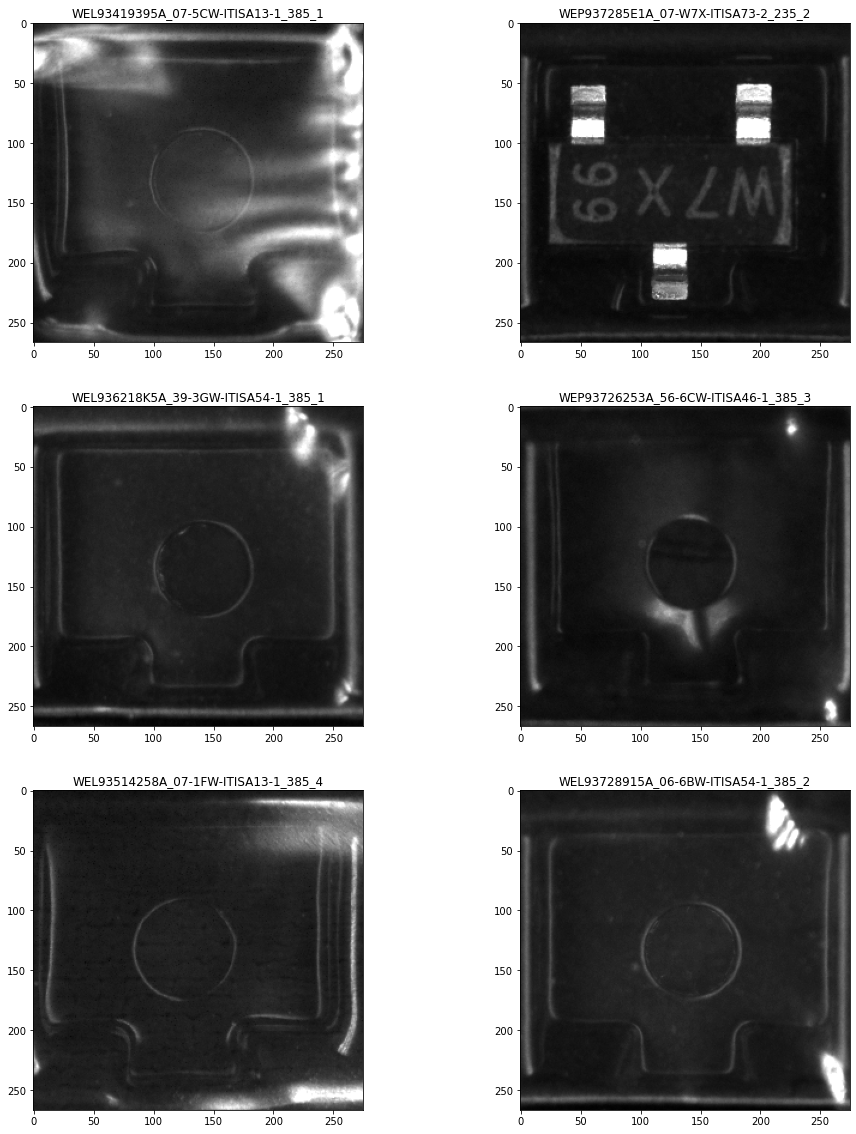

In [10]:
random.seed(42)
_, axes = plt.subplots(3,2,figsize=(16,20))
for i in range(3):
    f = random.choice(ts.values)
    p = expand_path(f)
    img = Image.open(p)
    axes[i][0].imshow(img,cmap='gray')
    axes[i][0].set_title(f)
    
    f = random.choice(ts.values)
    p = expand_path(f)
    img = Image.open(p)
    axes[i][1].imshow(img,cmap='gray')
    axes[i][1].set_title(f)

# Class imblanace

In [11]:
len(filenames),len(labels)

(34459, 34459)

In [12]:
df_new = pd.DataFrame(list(zip(filenames,labels)),columns=['id','label'])

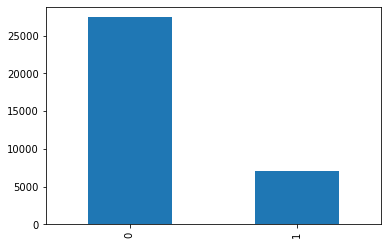

In [13]:
df_new['label'].value_counts().plot(kind='bar')

In [14]:
df_new['label'].value_counts()

0    27420
1     7039
Name: label, dtype: int64

We have 34459 train images in the dataset, good vs defect are roughly 1:4, which means **if test set are in the similar distribution**, simply predict good will result 80% correct in accuracy

### Full dataset EDA

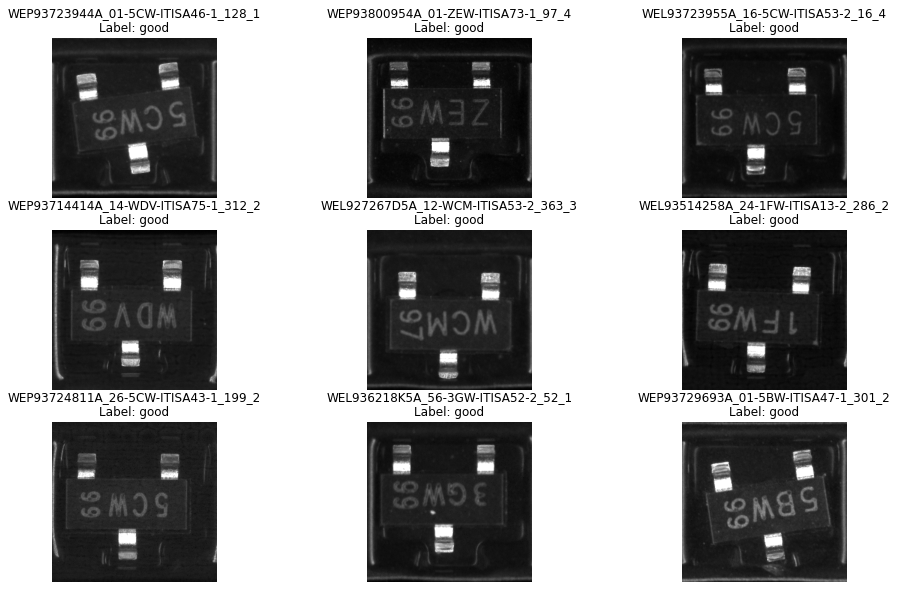

In [15]:
rows = 3

_, axes = plt.subplots(rows,rows,figsize=(16,10))

for i in range(rows):
    for j in range(rows):
        ts = df_new.sample()
        idx = ts['id'].values[0]
        label = ts['label'].values[0]
        f = expand_path(idx)
        img = Image.open(f)
        axes[i][j].imshow(img,cmap='gray')
        axes[i][j].set_title((f'{idx}\nLabel: defect') if label else (f'{idx}\nLabel: good') )
        axes[i][j].set_axis_off()

As we scan over the dataset, we can easily identify some defect chips

# Duplicates

### Let's check if the dataset contain duplicates

If you split a duplicates into both train and validation, there is a chance that your local cv has a high score but low test result. 

Let's make sure we don't have this problem, also, do we have examples appear in both tran and test?

# How to check duplicates?

I often run to the case that need to run a full scale large dataset to check if there are duplicates.

The most easy way for me is the following:

1. Hash the image pixel values
2. Check if any hash values are identical

The code below is trival, you can use any hash method you like. But this is a really fast way to scan a large dataset, as you can see, it only takes us 30s to run more than 40k images



**GOTCHAS:**

***If the image pixel shifted, hash won't work***


In [16]:
df_test = pd.DataFrame(test_filenames,columns=['id'])
df_test['label'] = np.nan
df_new = df_new.append(df_test)

In [17]:
img_meta_l = Parallel(n_jobs=psutil.cpu_count(), verbose=1)(
    (delayed(getImageMetaData)(fp) for fp in df_new['id']))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 116 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 4740 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 12740 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done 23940 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 38216 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 38289 out of 38289 | elapsed:   44.0s finished


In [18]:
img_meta_df = pd.DataFrame(np.array(img_meta_l))
img_meta_df.columns = ['id', 'strMd5']
df_new = df_new.merge(img_meta_df,on='id')
df_new['strMd5_count'] = df_new.groupby('strMd5')['id'].transform('count')
df_new['strMd5_train_count'] = df_new['strMd5'].map(df_new.groupby('strMd5')['label'].apply(lambda x:x.notnull().sum()))
df_new['strMd5_nunique'] = df_new.groupby('strMd5')['label'].transform('nunique').astype('int')
df_new[df_new.strMd5_count>1].strMd5_count.value_counts()

2    28
4     8
Name: strMd5_count, dtype: int64

# Duplicates in the train set with different filename

### The filename contains APG_ITIS seems to be the dupilcates

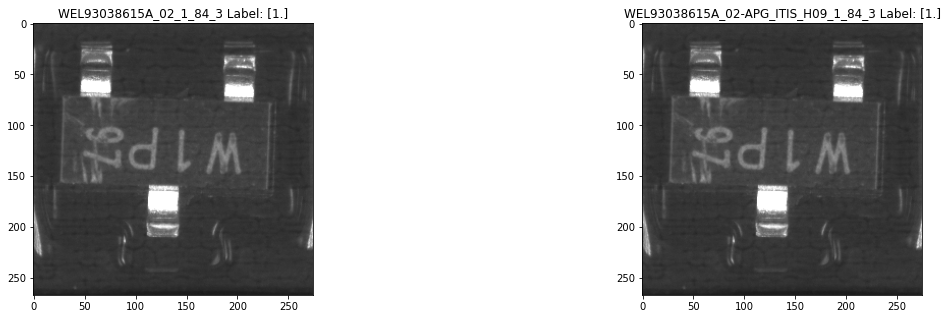

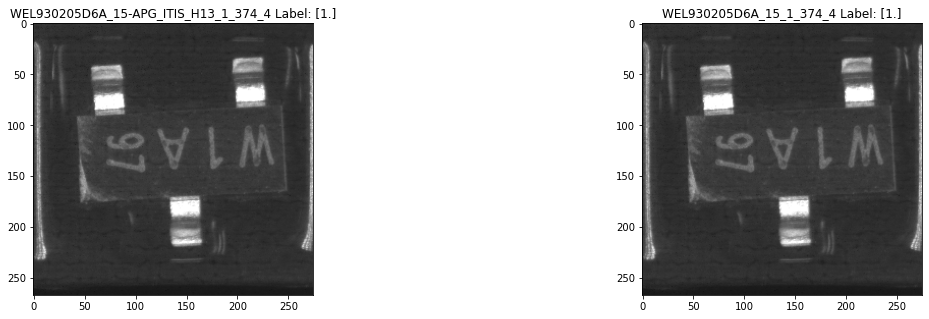

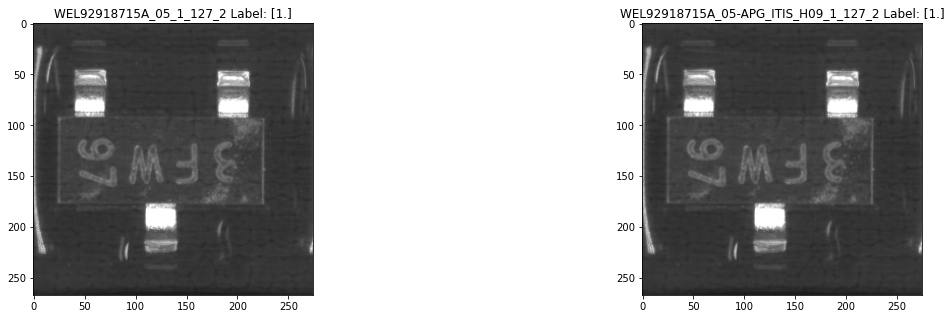

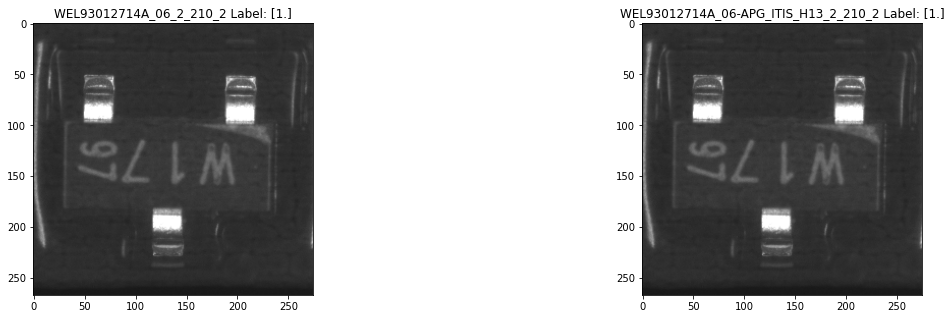

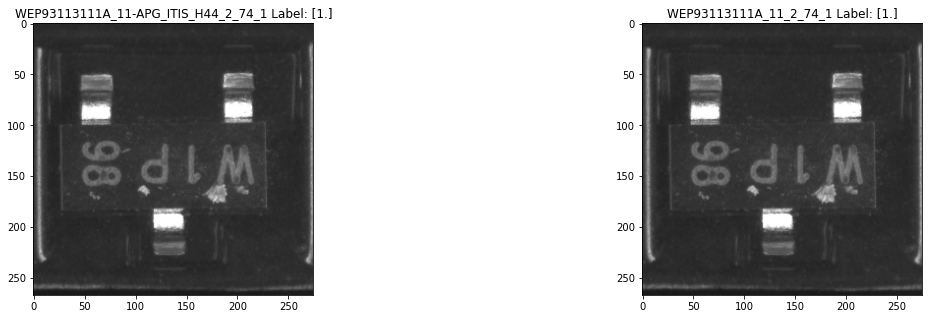

In [19]:
strMd51 = df_new[(df_new.strMd5_count>1)&(df_new.strMd5_nunique==1)].strMd5.unique()
#strMd5 = strMd51[0]
for strMd5 in strMd51[:5]:
    size = len(df_new[df_new['strMd5'] == strMd5]['id'])
    fig = plt.figure(figsize = (20, 5))
    for idx, img_name in enumerate(df_new[df_new['strMd5'] == strMd5]['id'][:size]):
        y = fig.add_subplot(1, size, idx+1)
        img = cv2.imread(expand_path(img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        class_id = df_new[df_new['id']==img_name]['label'].values
        y.set_title(img_name+f' Label: {class_id}')
        y.imshow(img)
    plt.show()

# Duplicates appears in train and test

### It would be nice if we can have some understanding of our test set

In [20]:
df_new[(df_new['strMd5_count']>1)&(df_new['label'].isnull())]

,id,label,strMd5,strMd5_count,strMd5_train_count,strMd5_nunique
2330,WEP934118D3A_41-APG_ITIS_H51_2_84_1,NaN,d968c0b5a8b734a657c816e30243298e,4,2,1
2331,WEP934118D3A_41-APG_ITIS_H51_2_84_1,NaN,d968c0b5a8b734a657c816e30243298e,4,2,1
7007,WEP93509812A_22-APG_ITIS_H50_2_180_4,NaN,e13556fd991cf7b5ab274b0e0dab989c,4,2,1
7008,WEP93509812A_22-APG_ITIS_H50_2_180_4,NaN,e13556fd991cf7b5ab274b0e0dab989c,4,2,1
34845,WEP930445J2A_26_2_368_4,NaN,2e6a51ed18d3484750bc396111615ba4,2,1,1


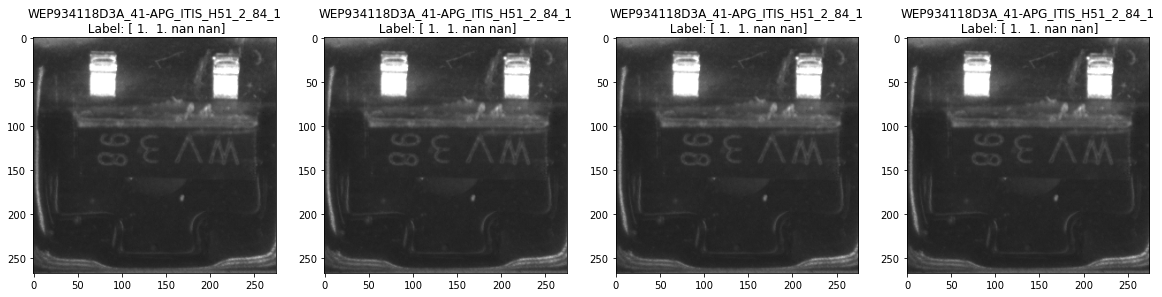

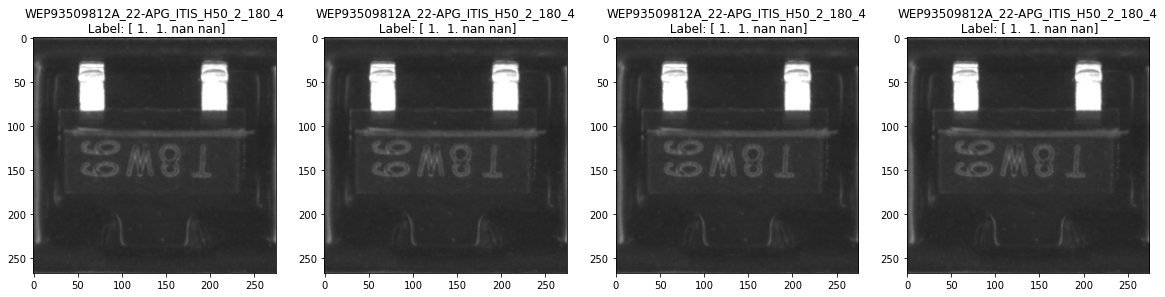

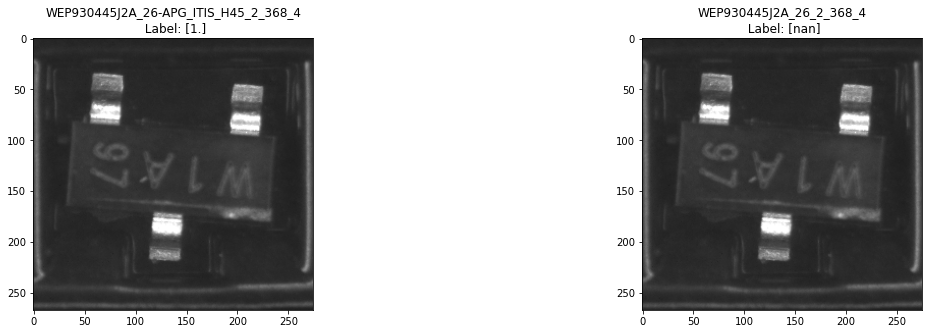

In [21]:
strMd51 = df_new[(df_new['strMd5_count']>1)&(df_new['label'].isnull())].strMd5.unique()

for strMd5 in strMd51:
    size = len(df_new[df_new['strMd5'] == strMd5]['id'])
    fig = plt.figure(figsize = (20, 5))
    for idx, img_name in enumerate(df_new[df_new['strMd5'] == strMd5]['id'][:size]):
        y = fig.add_subplot(1, size, idx+1)
        img = cv2.imread(expand_path(img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        class_id = df_new[df_new['id']==img_name]['label'].values
        y.set_title(img_name+f'\n Label: {class_id}')
        y.imshow(img)
    plt.show()

### Why we have label 1.1.nan.nan, are we having same file appear in both train and test?

In [22]:
df_new[df_new['id']=='WEP934118D3A_41-APG_ITIS_H51_2_84_1']

,id,label,strMd5,strMd5_count,strMd5_train_count,strMd5_nunique
2328,WEP934118D3A_41-APG_ITIS_H51_2_84_1,1.0,d968c0b5a8b734a657c816e30243298e,4,2,1
2329,WEP934118D3A_41-APG_ITIS_H51_2_84_1,1.0,d968c0b5a8b734a657c816e30243298e,4,2,1
2330,WEP934118D3A_41-APG_ITIS_H51_2_84_1,NaN,d968c0b5a8b734a657c816e30243298e,4,2,1
2331,WEP934118D3A_41-APG_ITIS_H51_2_84_1,NaN,d968c0b5a8b734a657c816e30243298e,4,2,1


seems like someone accidentaly split train file into your test file, you might consider them as "free answers" :)

So a good way to do is to make sure you don't split this files into your validation

# Submit

If you want to submit to kaggle, you need to genereate a submission file

In [23]:
df_final = pd.read_csv(path/'submission_sample.csv')
df_final.head()

,id,defect_score
0,WEP937068H1A_21-5CW-ITISA46-1_254_2,0.796026
1,WEP93700163A_51-APG_ITIS_H13_2_179_1,0.017542
2,WEP937078H4A_38-5CW-ITISA44-1_42_2,0.405371
3,WEA938001H3A_41-5CW-ITISA51-1_40_2,0.521858
4,WEL92208756A_02-U3W-ITISA09-2_165_3,0.510282


In [24]:
df_final.shape, df_test.shape

((3830, 2), (3830, 2))

seems like we can just turn this one in, let's try

In [25]:
df_final.to_csv('submission.csv',index=False)